In [3]:
from sklearn.datasets import load_iris
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
import time

import numpy as np
import os
import subprocess
import math
import matplotlib.pyplot as plt


2000


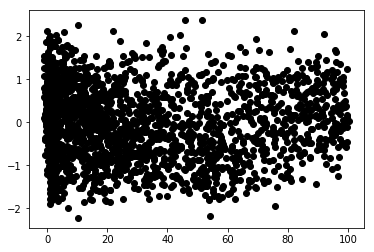

In [4]:
noise = 0.5
N = 2000


a=10 * (np.random.rand(N))#; print(a)
b=10 * (np.random.rand(N))#; print(b)

yerr = noise * np.ones_like(a)
y =np.cos((a**2+b**2)/20) + yerr * np.random.randn(len(a))

X = np.ones(shape = (2,N))
X[0] = a
X[1] = b

X = X.T

print(len(X))
plt.plot(a**2+np.sin(b),y, 'ko')


--- 658.473358154 Scikit seconds ---
('rms: ', 0.06692003012641376)


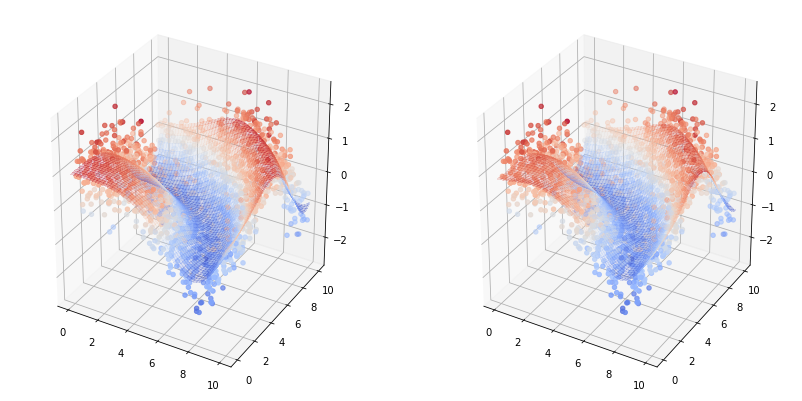

In [6]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D



start_time = time.time()
kernel = ConstantKernel() + 1.0 * RBF(1)+ WhiteKernel(noise_level=noise)
gpc = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20).fit(X, y)
gpc.score(X, y) 



#x = 10*np.random.rand(2000).reshape(1000,2)
rx, ry = np.linspace(0,10,100), np.linspace(0,10,100)
a0, b0 = np.meshgrid(rx, rx)

x = np.c_[a0.ravel(), b0.ravel()]

y_pred, sigma = gpc.predict(x, return_std=True)
print("--- %s Scikit seconds ---" % (time.time() - start_time))

y_real =np.cos((a0**2+b0**2)/20)
plt.figure(figsize=(14,7))
ax = plt.gcf().add_subplot(1,2,1, projection='3d')
ax.plot_surface(a0, b0, y_real.reshape(a0.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
ax.scatter(a,b,y, c=y, cmap=cm.coolwarm)

ax = plt.gcf().add_subplot(1,2,2, projection='3d')
ax.plot_surface(a0, b0, y_pred.reshape(a0.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
ax.scatter(a,b,y, c=y, cmap=cm.coolwarm)

Y_model = y_pred.ravel()
Y_gp    = y_real.ravel()
print('rms: ', np.sqrt(np.mean((Y_model-Y_gp)**2)))

      fun: 1559.9972493458556
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00013642, 0.        ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 8
   status: 0
  success: True
        x: array([2.11248957, 0.80084394])
--- 34.3622200489 ESN seconds ---
('rms: ', 0.06685257226766272)


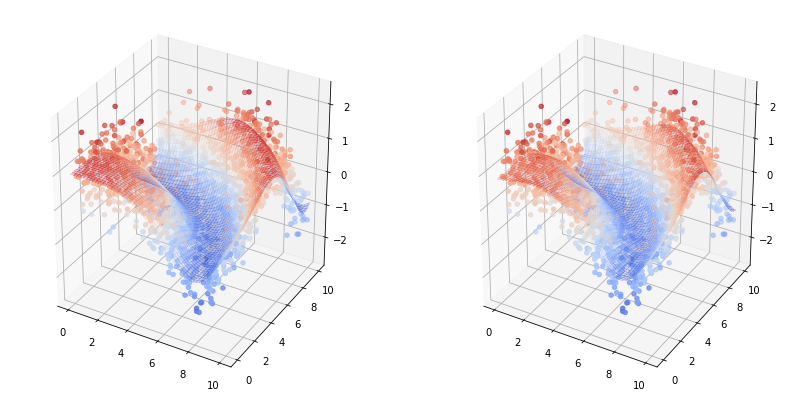

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    ''' Isotropic squared exponential kernel. Computes a covariance matrix from points in X1 and X2. Args: X1: Array of m points (m x d). X2: Array of n points (n x d). Returns: Covariance matrix (m x n). '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

# Prediction from noise-free training data

from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    ''' Computes the suffifient statistics of the GP posterior predictive distribution from m training data X_train and Y_train and n new inputs X_s. Args: X_s: New input locations (n x d). X_train: Training locations (m x d). Y_train: Training targets (m x 1). l: Kernel length parameter. sigma_f: Kernel vertical variation parameter. sigma_y: Noise parameter. Returns: Posterior mean vector (n x d) and covariance matrix (n x n). '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s



from numpy.linalg import cholesky
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise):
    ''' Returns a function that computes the negative log-likelihood for training data X_train and Y_train and given noise level. Args: X_train: training locations (m x d). Y_train: training targets (m x 1). noise: known noise level of Y_train. Returns: Minimization objective. '''
    def step(theta):
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        # Compute determinant via Cholesky decomposition
        return np.sum(np.log(np.diagonal(cholesky(K)))) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    return step

start_time = time.time()

res = minimize(nll_fn(X, y, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

print res
# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x


rx, ry = np.linspace(0,10,100), np.linspace(0,10,100)
a0, b0 = np.meshgrid(rx, rx)

x = np.c_[a0.ravel(), b0.ravel()]



# Compute mean and covariance of the posterior predictive distribution
y_pred, sigma = posterior_predictive(x, X, y, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
print("--- %s ESN seconds ---" % (time.time() - start_time))


y_real =np.cos((a0**2+b0**2)/20)
plt.figure(figsize=(14,7))
ax = plt.gcf().add_subplot(1,2,1, projection='3d')
ax.plot_surface(a0, b0, y_real.reshape(a0.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
ax.scatter(a,b,y, c=y, cmap=cm.coolwarm)



ax = plt.gcf().add_subplot(1,2,2, projection='3d')
ax.plot_surface(a0, b0, y_pred.reshape(a0.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
ax.scatter(a,b,y, c=y, cmap=cm.coolwarm)


Y_model = y_pred.ravel()
Y_gp    = y_real.ravel()
print('rms: ', np.sqrt(np.mean((Y_model-Y_gp)**2)))


      fun: 1559.8363495832243
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.73070497e-04, -1.36424205e-04,  4.54747351e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 12
   status: 0
  success: True
        x: array([2.19320185, 2.01718123, 0.79864851])
('rms: ', 0.06712541322074858)


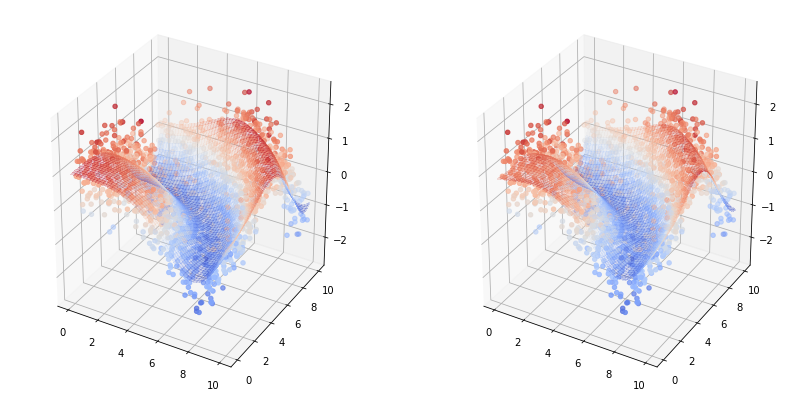

In [8]:
def kernel2(X1, X2, l, sigma_f=1.0):
    
    l = np.asarray(l)
    L1 = np.zeros_like(X1)+l
    L2 = np.zeros_like(X2)+l
    
    X1_ = X1/L1
    X2_ = X2/L2
    
    ''' Isotropic squared exponential kernel. Computes a covariance matrix from points in X1 and X2. Args: X1: Array of m points (m x d). X2: Array of n points (n x d). Returns: Covariance matrix (m x n). '''
    sqdist = np.sum(X1_**2, 1).reshape(-1, 1) + np.sum(X2_**2, 1) - 2 * np.dot(X1_, X2_.T)
    return sigma_f**2 * np.exp(-0.5 * sqdist)

# Prediction from noise-free training data


def posterior_predictive2(X_s, X_train, Y_train, l, sigma_f=1.0, sigma_y=1e-8):
    ''' Computes the suffifient statistics of the GP posterior predictive distribution from m training data X_train and Y_train and n new inputs X_s. Args: X_s: New input locations (n x d). X_train: Training locations (m x d). Y_train: Training targets (m x 1). l: Kernel length parameter. sigma_f: Kernel vertical variation parameter. sigma_y: Noise parameter. Returns: Posterior mean vector (n x d) and covariance matrix (n x n). '''
    K = kernel2(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel2(X_train, X_s, l, sigma_f)
    K_ss = kernel2(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s


def nll_fn2(X_train, Y_train, noise):
    ''' Returns a function that computes the negative log-likelihood for training data X_train and Y_train and given noise level. Args: X_train: training locations (m x d). Y_train: training targets (m x 1). noise: known noise level of Y_train. Returns: Minimization objective. '''
    def step(theta):
        K = kernel2(X_train, X_train, [theta[0], theta[1]], sigma_f=theta[2]) + \
            noise**2 * np.eye(len(X_train))
        # Compute determinant via Cholesky decomposition
        return np.sum(np.log(np.diagonal(cholesky(K)))) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    return step


res = minimize(nll_fn2(X, y, noise), [2, 2, 2], 
               bounds=((1e-5, None), (1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

print res
# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l1_opt, l2_opt, sigma_f_opt = res.x


rx, ry = np.linspace(0,10,100), np.linspace(0,10,100)
a0, b0 = np.meshgrid(rx, rx)

x = np.c_[a0.ravel(), b0.ravel()]



# Compute mean and covariance of the posterior predictive distribution
y_pred, sigma = posterior_predictive2(x, X, y, [l1_opt, l2_opt], sigma_f=sigma_f_opt, sigma_y=noise)


y_real =np.cos((a0**2+b0**2)/20)
plt.figure(figsize=(14,7))
ax = plt.gcf().add_subplot(1,2,1, projection='3d')
ax.plot_surface(a0, b0, y_real.reshape(a0.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
ax.scatter(a,b,y, c=y, cmap=cm.coolwarm)



ax = plt.gcf().add_subplot(1,2,2, projection='3d')
ax.plot_surface(a0, b0, y_pred.reshape(a0.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
ax.scatter(a,b,y, c=y, cmap=cm.coolwarm)


Y_model = y_pred.ravel()
Y_gp    = y_real.ravel()
print('rms: ', np.sqrt(np.mean((Y_model-Y_gp)**2)))